In [1]:
import numpy as np
import networkx as nx
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
folder = '2.1_results/'

In [3]:
df_seed_genes = pd.read_csv("Seed_Genes.csv", sep = "\t")
df_seed_genes.head()

,seed Gene,Uniprot_AC,protein_name,entrez_gene_id,description
0,IFNG,P01579,Interferon gamma,3458,Produced by lymphocytes activated by specific ...
1,CD28,P10747,T-cell-specific surface glycoprotein CD28,940,"Involved in T-cell activation, the induction o..."
2,HLA-B,P01889,"HLA class I histocompatibility antigen, B alph...",3106,Antigen-presenting major histocompatibility co...
3,KIR3DL1,P43629,Killer cell immunoglobulin-like receptor 3DL1,3811,Receptor on natural killer (NK) cells for HLA ...
4,HLA-C,P10321,"HLA class I histocompatibility antigen, C alph...",3107,Antigen-presenting major histocompatibility co...


In [4]:
df_SGI = pd.read_csv("SeedGeneInteractome.csv", sep = "\t")
df_SGI.head()

,interactor A gene symbol,interactor B gene symbol,interactor A Uniprot AC,interactor B Uniprot AC,database source
0,IFNG,IFNG,P01579,P01579,Biogrid
1,HLA-B,HLA-B,P01889,P01889,Biogrid
2,HLA-B,ADRB2,P01889,P07550,Biogrid
3,HLA-B,HLA-C,P01889,P10321,Biogrid
4,KIR3DL1,KIR3DL1,P43629,P43629,Biogrid


In [5]:
df_I = pd.read_csv("IntersectionInteractome.csv", sep = "\t")
df_I.head()


,interactor A gene symbol,interactor B gene symbol,interactor A Uniprot AC,interactor B Uniprot AC
0,DHX15,ARRB2,O43143,P32121
1,CAD,HDAC6,P27708,Q9UBN7
2,RPL7,RPS13,P18124,P62277
3,MYC,HSP90AA1,P01106,P07900
4,TP53,GNL3,P04637,Q9BVP2


In [6]:
df_U = pd.read_csv("UnionInteractome.csv", sep = "\t")
df_U.head()

,interactor A gene symbol,interactor B gene symbol,interactor A Uniprot AC,interactor B Uniprot AC
0,IFNG,RP3-503F13.3,P01579,-
1,IFNG,GOPC,P01579,Q9HD26
2,IFNG,IFNGR2,P01579,P38484
3,IFNG,STAT6,P01579,P42226
4,IFNG,IFNG,P01579,P01579


In [7]:
def make_graph(df):
    G =  nx.Graph()

    node_list = pd.concat( [df['interactor A gene symbol'], df['interactor B gene symbol']], axis=0).unique()
    edge_list = df[['interactor A gene symbol', 'interactor B gene symbol']].to_numpy()
    
    G.add_edges_from(edge_list)
    
    return G

In [8]:
G = make_graph(df_SGI)

/Users/miguel/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


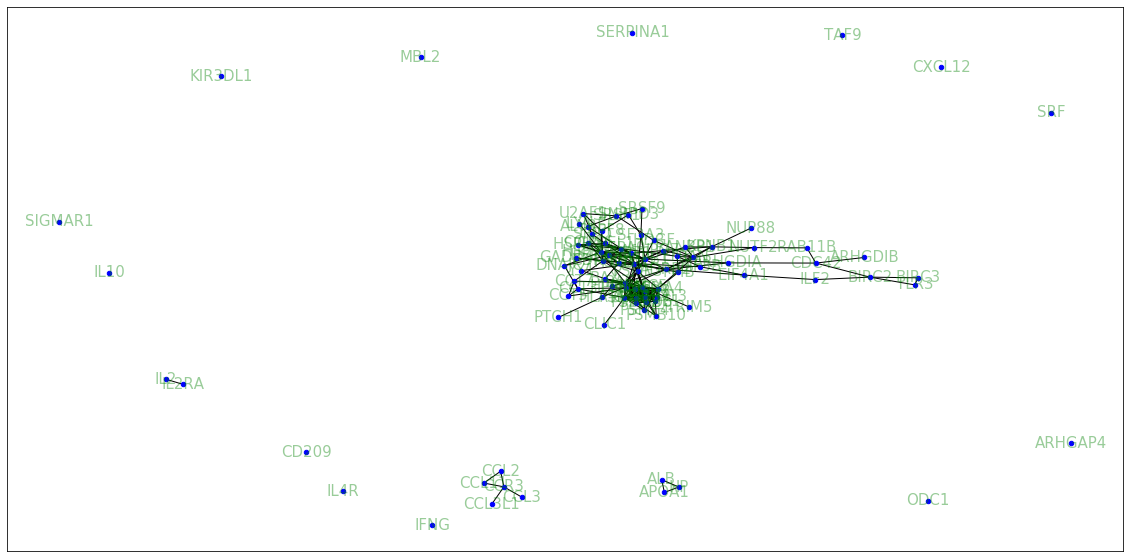

In [9]:
if 1:
    fig = plt.figure(figsize=(20,10))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                           node_color = 'blue', node_size = 20)
    nx.draw_networkx_labels(G, pos, font_color='green', font_size=15, alpha=0.4)
    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)

## 2.1) Calculate the main network measures for SGI, I and U

## a) global measures of SGI, U and I

In [10]:
def APL_diameter_radius(G):
    """
    Compute the average path lenght of graph G and the diameter
    ``APL:
        It computes the average path lenght according to the formula (see APL formula)
        In case of two not connected vertex v_i and v_j the distance is supposed to be 0
      diameter:
        Diameter computed as the max(eccentricity)
      radius:
        radius computed as the min(eccentricity)
        
    NOTE: G has to be a graph (at least 2 nodes and 1 edge)
    ``
    """
    N = G.order()   # n of nodes
    
    # dictionary containing all the shortest paths i.e. {node_i: {node_j:1, node_k:3, ...}}
    shortest_paths_dict = dict(nx.all_pairs_shortest_path_length(G))
    
    # initializing diameter at 0 and radius at np.inf!
    diameter = 0
    radius = np.inf
    
    # initializing the sum of the shortest paths 
    sum_deltas = 0
    
    for node in shortest_paths_dict:
        
        # all the shortest paths from node_i
        node_sp_list = list(shortest_paths_dict[node].values())
        sum_deltas += np.sum(node_sp_list)
        
        # eccentricity of node_i (minimum value is 1)
        eccentricity = max(1, np.max(node_sp_list))
        
        if eccentricity > diameter:
            diameter = eccentricity
            
        if eccentricity < radius:
            radius = eccentricity
        
    # Average_path_lenght
    APL = sum_deltas / (N-1) / N
    
    return APL, diameter, radius


def GCC(G):
    """
    Compute the Global clustering coefficient
    according to the equation 1/N * sum(LCC_i)
    where LCC_i is the local clustering coefficient of the i-th node
    """
    
    N = G.order()
    all_LCCs = list(nx.clustering(G, G.nodes).values())
    
    return np.sum(all_LCCs) / N

def compute_centralization(G):
    """
    Compute the centralization metric of graph G with the formula
        N / (N-2) * (max(degree)/(N-1) - Density)
    """
    N = G.order()
    max_degree = max(dict(G.degree).values())
    
    centralization = N/(N-2) * ((max_degree/(N-1)) - nx.density(G))
    return centralization
    

def count_connected_isolated(Graph):
    G = Graph.copy()
    
    # removing the edges of i-th node with itself
    # to see if nodes have only self loops (hence are isolated)
    
    for edge in list(G.edges()):
        if edge[0]==edge[1]:
            G.remove_edge(edge[0], edge[1])    
    
    n_isolated = len(list(nx.isolates(G)))
    n_connected = nx.number_connected_components(G) - n_isolated
    
    return n_isolated, n_connected

In [11]:
def global_measures(G):
    
    
    # removing the edges of i-th node with itself
    # in order to compute the right metrics
    #for edge in list(G.edges()):
    #    if edge[0]==edge[1]:
    #        G.remove_edge(edge[0], edge[1])

    n_nodes = G.order()    # number of nodes
    n_links = len(G.edges) # number of links

    #n_isolated = len(list(nx.isolates(G)))
    #n_connected = nx.number_connected_components(G)-n_isolated

    n_isolated, n_connected = count_connected_isolated(G)
    APL, diameter, radius = APL_diameter_radius(G)

    avg_degree = 2*len(G.edges)/len(G.nodes)

    Global_CC = GCC(G)
    centralization = compute_centralization(G)
    
    res = [n_nodes, n_links, n_connected, n_isolated, APL  ,
           avg_degree, Global_CC, diameter, radius, centralization]
    
    return res

In [12]:
# COMPARE nx functions and our APL_diameter_radius() function
# using CONNECTED COMPONENTS (subgraphs) from graph G
G = make_graph(df_SGI)
components_list = list(nx.connected_component_subgraphs(G))

print('----- networkx functions -----')

for graph in components_list:
    # if it's a connected component (not only one node)
    if len(graph.edges) > 1:
        print(graph.order(),' ', end='')
        print(nx.average_shortest_path_length(graph), nx.diameter(graph), nx.radius(graph))
    
print('----- APL, diameter, radius -----')
for graph in components_list:
    if len(graph.edges) > 1:
        print(graph.order(),' ', end='')
        print(*APL_diameter_radius(graph))
    

----- networkx functions -----
68  3.0851624231782266 7 4
5  1.5 2 1
2  1.0 1 1
3  1.0 1 1
----- APL, diameter, radius -----
68  3.0851624231782266 7 4
5  1.5 2 1
2  1.0 1 1
3  1.0 1 1


In [13]:
colnames = ['Network', 'n_nodes', 'nlinks', 'conn_components', 'n_isolated', 'AvgPathLen', 
            'avgDegree', 'GCC', 'diameter', 'radius', 'centralization']

res = []

G = make_graph(df_SGI)
res.append(['SeedGeneInteractome'] + global_measures(G))

G = make_graph(df_I)
res.append(['IntersectionInteractome'] + global_measures(G))


print('longest graph')
from time import time
t = time()
G = make_graph(df_U)
res.append(['UnionInteractome'] + global_measures(G))
print(time()-t, 's')

df1 = pd.DataFrame(res, columns=colnames)
df1.head()

longest graph
595.9058330059052 s


,Network,n_nodes,nlinks,conn_components,n_isolated,AvgPathLen,avgDegree,GCC,diameter,radius,centralization
0,SeedGeneInteractome,91,271,4,13,1.720879,5.956044,0.312470,7,1,0.148190
1,IntersectionInteractome,1151,7630,10,8,3.123002,13.258036,0.243175,9,1,0.152214
2,UnionInteractome,5627,108996,2,0,2.860483,38.740359,0.182044,6,1,0.158119


In [14]:
df1.to_csv(folder+'global_measures.csv', index=False)

## 2.1 b)  Isolate  the  largest  connected  component  (LCC)  of  I  and  U  and  calculate  the  following

# global measures:


In [15]:
def get_LCC(G):
    
    components_list = list(nx.connected_component_subgraphs(G))

    n_nodes_list = [graph.order() for graph in components_list]
    LCC_idx = n_nodes_list.index(max(n_nodes_list))
    
    return components_list[LCC_idx].copy()

In [16]:
# we can re-use the previous function (global_measures(G)) 
# and then drop the useless columns (conn_components which is 1, n_isolated which is 0)
# or also keep them and merge the results with previous df

colnames = ['Network', 'n_nodes', 'nlinks', 'conn_components', 'n_isolated', 'AvgPathLen', 
            'avgDegree', 'GCC', 'diameter', 'radius', 'centralization']

res = []

G = make_graph(df_SGI)
LCC = get_LCC(G)
res.append(['SeedGeneInteractome_LCC'] + global_measures(LCC))

G = make_graph(df_I)
LCC = get_LCC(G)
res.append(['IntersectionInteractome_LCC'] + global_measures(LCC))


print('longest graph')
from time import time
t1 = time()
G = make_graph(df_U)
LCC = get_LCC(G)
res.append(['UnionInteractome_LCC'] + global_measures(LCC))
print(time()-t1, 's')



df2 = pd.DataFrame(res, columns=colnames)

df2

longest graph
517.5852160453796 s


,Network,n_nodes,nlinks,conn_components,n_isolated,AvgPathLen,avgDegree,GCC,diameter,radius,centralization
0,SeedGeneInteractome_LCC,68,243,1,0,3.085162,7.147059,0.342179,7,4,0.182270
1,IntersectionInteractome_LCC,1120,7603,1,0,3.298304,13.576786,0.249906,9,5,0.156153
2,UnionInteractome_LCC,5624,108993,1,0,2.863535,38.759957,0.182141,6,4,0.158200


In [17]:
df2.to_csv(folder+'global_measures_LCC.csv', index=False)

## 2.1 b) Isolate the largest connected component (LCC) of I and U and calculate the following
# local (i.e. for each node) measures

In [18]:
def local_measures_df(G):
    from collections import defaultdict
    local_measures = defaultdict(list)

    degrees = nx.degree(G)
    betw_centrality = nx.betweenness_centrality(G)
    eig_centrality = nx.eigenvector_centrality(G)
    clos_centrality = nx.closeness_centrality(G)
    
    
    for key, value in degrees:
        local_measures[key].append(value)   # node degree

        local_measures[key].append(betw_centrality[key])   # betweenness_centrality

        local_measures[key].append(eig_centrality[key])    # eigenvector_centrality

        local_measures[key].append(clos_centrality[key])   # closeness_centrality

        local_measures[key].append(betw_centrality[key]/degrees[key])
        
    
    df =  pd.DataFrame.from_dict(local_measures, orient='index', 
                                 columns=['degree', 'Betweenness_centrality',
                                          'Eigenvector_centrality', 'Closeness_centrality',
                                          'betwennes/degree'])
    
    df.index = df.index.set_names(['node'])
    return df.reset_index()

In [19]:
G = make_graph(df_SGI)
LCC = get_LCC(G)
df_local_SGI = local_measures_df(LCC)
df_local_SGI.head(5)

,node,degree,Betweenness_centrality,Eigenvector_centrality,Closeness_centrality,betwennes/degree
0,HLA-B,4,0.000000,0.002287,0.299107,0.000000
1,ADRB2,11,0.187728,0.022713,0.418750,0.017066
2,HLA-C,5,0.029851,0.002304,0.300448,0.005970
3,PTCH1,3,0.000000,0.000211,0.231834,0.000000
4,TRIM5,3,0.000000,0.029642,0.300448,0.000000


In [20]:
df_local_SGI.to_csv(folder+'local_measures_SGI.csv', index=False)

In [21]:
from time import time

t = time()
G = make_graph(df_I)
LCC = get_LCC(G)
df_local_Intersection = local_measures_df(LCC)
print(time()-t, 's')
df_local_Intersection.head()


15.836300134658813 s


,node,degree,Betweenness_centrality,Eigenvector_centrality,Closeness_centrality,betwennes/degree
0,DHX15,22,0.002194,0.017762,0.343990,0.000100
1,ARRB2,41,0.008808,0.047477,0.382826,0.000215
2,CAD,16,0.002010,0.015981,0.346762,0.000126
3,HDAC6,23,0.002529,0.028581,0.351887,0.000110
4,RPL7,22,0.001136,0.013693,0.330576,0.000052


In [22]:
df_local_Intersection.to_csv(folder+'local_measures_IntersectionInteractome.csv', index=False)

In [23]:
from time import time

t = time()
G = make_graph(df_U)
LCC = get_LCC(G)
df_local_Union = local_measures_df(LCC)
print(time()-t, 's')
df_local_Union.head()

1023.7921800613403 s


,node,degree,Betweenness_centrality,Eigenvector_centrality,Closeness_centrality,betwennes/degree
0,IFNG,8,0.000357,1.047512e-04,0.291498,0.000045
1,RP3-503F13.3,1,0.000000,7.016708e-07,0.225715,0.000000
2,GOPC,42,0.000319,4.288995e-03,0.375042,0.000008
3,IFNGR2,8,0.000065,1.067587e-03,0.336545,0.000008
4,STAT6,47,0.000544,5.285064e-03,0.374168,0.000012


In [24]:
df_local_Union.to_csv(folder+'local_measures_UnionInteractome.csv', index=False)

## Figure of SGI and I-LCC:

In [1]:
import numpy as np
import networkx as nx
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df_SGI = pd.read_csv("SeedGeneInteractome.csv", sep = "\t")
df_I = pd.read_csv("IntersectionInteractome.csv", sep = "\t")

# seed genes for HIV Infections(C0019693)

seed_genes = pd.read_csv('C0019693_disease_gda_summary_CURATED.tsv',sep='\t',usecols=['Gene'])['Gene'].values

In [3]:
def make_graph(df):
    G =  nx.Graph()

    node_list = pd.concat( [df['interactor A gene symbol'], df['interactor B gene symbol']], axis=0).unique()
    edge_list = df[['interactor A gene symbol', 'interactor B gene symbol']].to_numpy()
    
    G.add_edges_from(edge_list)
    
    return G

In [4]:
G = make_graph(df_SGI)

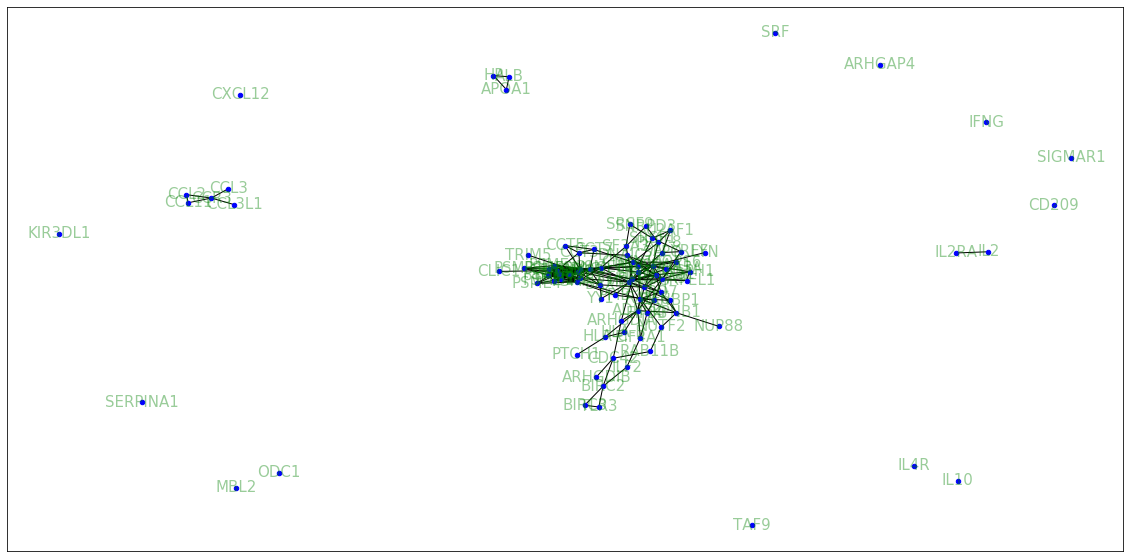

In [6]:
fig = plt.figure(figsize=(20,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'blue', node_size = 20)
nx.draw_networkx_labels(G, pos, font_color='green', font_size=15, alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)

In [7]:
G = make_graph(df_SGI)

In [8]:
def get_LCC(G):
    
    components_list = list(nx.connected_component_subgraphs(G))

    n_nodes_list = [graph.order() for graph in components_list]
    LCC_idx = n_nodes_list.index(max(n_nodes_list))
    
    return components_list[LCC_idx].copy()

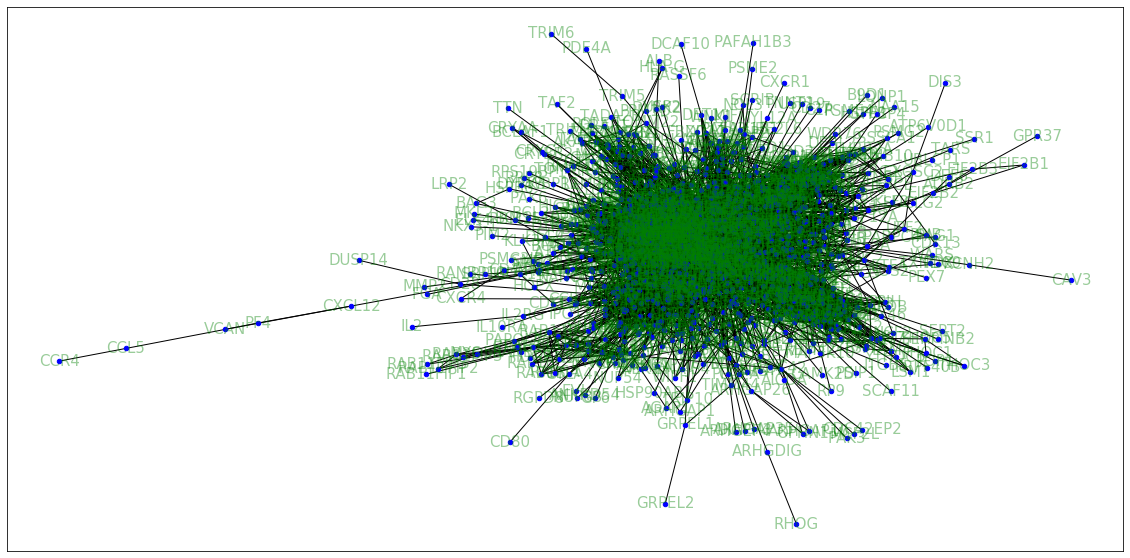

In [9]:
G = make_graph(df_I)
G = get_LCC(G)

fig = plt.figure(figsize=(20,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'blue', node_size = 20)
nx.draw_networkx_labels(G, pos, font_color='green', font_size=15, alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True)

In [110]:
import igraph as ig

G = make_graph(df_SGI)

nx.write_graphml(G,'graphs/SGI.graphml' ) # Export NX graph to file
g = ig.read('graphs/SGI.graphml',format="graphml") # Create new IG graph from file


# labels
g.vs['label'] = g.vs["id"]

# plotting options
visual_style = {}
layout = g.layout('kk')         # layout
visual_style["layout"] = layout # layout

g.es["color"] = "lightgrey"         # edges color
visual_style["vertex_size"] = 40    # vertex size
visual_style["bbox"] = (1200, 1200) # img size
visual_style["margin"] = 40         # img size

# color seed genes
g.vs["color"] = ["lightblue" for gene in g.vs["label"] if gene in seed_genes]

ig.plot(g, "graphs/SGI.png", **visual_style)

In [143]:
G = make_graph(df_I)
G = get_LCC(G)

# from nx graph to igraph conversion
nx.write_graphml(G,'graphs/I_LCC.graphml' ) # Export NX graph to file
g = ig.read('graphs/I_LCC.graphml',format="graphml") # Create new IG graph from file

# label
g.vs['label'] = [gene if gene in seed_genes else None for gene in g.vs["id"]]
layout = g.layout('kk')

# edges color
g.es["color"] = "lightgrey"


visual_style = {}
# size (bigger for seed genes)
visual_style["vertex_size"] = [40 if gene in seed_genes else 20 for gene in g.vs["id"]]
# layout
visual_style["layout"] = layout
visual_style["bbox"] = (1200, 1200)
visual_style["margin"] = 40

# color (lightblue for seed genes, orange otherwise)
g.vs["color"] = ["lightblue" if gene in seed_genes else "orange" for gene in g.vs["id"] ]
ig.plot(g, "graphs/I_LCC.png", **visual_style)

In [58]:
g.vertex_attributes()

['id', 'name', 'label']

## Table with the first 20 highest ranking genes for betweenness

For I-LCC and U-LCC

In [10]:
# I-LCC
pd.read_csv('2.1_results/local_measures_IntersectionInteractome.csv').sort_values('Betweenness_centrality', ascending=False).head(20)

,node,degree,Betweenness_centrality,Eigenvector_centrality,Closeness_centrality,betwennes/degree
8,TP53,188,0.130845,0.263871,0.471158,0.000696
297,UNK,63,0.045196,0.034680,0.387734,0.000717
7,HSP90AA1,80,0.043093,0.089517,0.416760,0.000539
397,COPS5,84,0.041753,0.103774,0.425637,0.000497
38,GRB2,73,0.037595,0.036331,0.378552,0.000515
137,HSPA8,75,0.031926,0.085765,0.416450,0.000426
231,BRCA1,99,0.026973,0.176640,0.424185,0.000272
79,EP300,113,0.025230,0.203065,0.415367,0.000223
138,CTNNB1,77,0.025126,0.130698,0.415522,0.000326
203,MDM2,75,0.023320,0.104554,0.402663,0.000311


In [12]:
# I-LCC
pd.read_csv('2.1_results/local_measures_UnionInteractome.csv').sort_values('Betweenness_centrality', ascending=False).head(20)

,node,degree,Betweenness_centrality,Eigenvector_centrality,Closeness_centrality,betwennes/degree
449,HSP90AA1,917,0.097185,0.069821,0.501293,0.000106
658,BAG3,463,0.055472,0.022548,0.455820,0.000120
490,MDM2,545,0.042967,0.053307,0.472005,0.000079
545,HSPB1,412,0.040146,0.034324,0.454127,0.000097
33,ADRB2,325,0.034484,0.021538,0.434208,0.000106
605,NTRK1,919,0.028771,0.120697,0.507720,0.000031
268,APP,611,0.026880,0.054197,0.476930,0.000044
1566,HSPD1,301,0.023551,0.032041,0.446660,0.000078
713,MYC,928,0.023113,0.127789,0.497655,0.000025
2049,KPNB1,292,0.021126,0.030181,0.434343,0.000072
